In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as plt_ticker

outfolder = "pngs_V7"
if not os.path.exists(outfolder):
    os.makedirs(outfolder)

## Some helpful functions:

In [12]:
def get_random_on_shpere(d=10):
    x_rand = np.random.normal(size=d)
    x_rand = x_rand / np.linalg.norm(x_rand)
    return x_rand

def get_random_normal(d=10):
    return np.random.normal(size=d)

def norm(x):
    return np.linalg.norm(x)

def relu(x):
    return np.maximum(0,x)

x = get_random_on_shpere()
print("x sampled on sphere:", x)
print("x@x:", x@x)
print("norm(x):", norm(x))

print("\nRelu([-1,0,1]):", relu(np.array([-1,0,1])))

print("\nDiffernent values of d & x@x: (x random normal)")
d_vals = [2, 5, 10, 20, 50, 100]
for d in d_vals:
    x = get_random_normal(d=d)
    print(d, x@x)


print("\nExpectation and Variance of $\sigma(N(0,1))$:")
mu = 1/2 * np.sqrt(2/np.pi)
print("mu:", mu)
sigma_sq = 1/2 - mu**2
print("sigma squared:", sigma_sq)
sigma = np.sqrt(sigma_sq)
print("sigma:", sigma)

x sampled on sphere: [-0.49608509 -0.1678779  -0.48350907 -0.09528933  0.28424915 -0.30824554
 -0.02000082 -0.36425549 -0.36012506 -0.21040549]
x@x: 1.0
norm(x): 1.0

Relu([-1,0,1]): [0 0 1]

Differnent values of d & x@x: (x random normal)
2 1.316181579068357
5 10.64707663107968
10 8.05986921727821
20 22.007554560672897
50 69.89716990462088
100 106.31377013409768

Expectation and Variance of $\sigma(N(0,1))$:
mu: 0.3989422804014327
sigma squared: 0.3408450569081046
sigma: 0.5838193701035489


## Network class:

In [27]:
class network:
    def __init__(self, N, d, on_sphere=True, nrof_repeats=1):
        """
        nrof_repeats .. Number of time each weight is repeated.
        """
        self.N = N # Range of weight value
        self.d = d # Weight dimension, i.e. amount of weight scalars
        self.on_sphere =  on_sphere
        if on_sphere:
            self.ws = np.array([get_random_on_shpere(d=d) for _ in range(self.N)])
        else:
            # self.ws = np.array([get_random_on_shpere(d=d) for _ in range(self.N)])
            ws = []
            for _ in range(self.N//nrof_repeats):
                w = get_random_normal(d=d)
                for _ in range(nrof_repeats):
                    ws.append(w)
            self.ws = np.array(ws)
        print(self.ws.shape)
        
    def __call__(self, x):
        ip = x@self.ws.T
        ip_relu = relu(ip)
        output = np.mean(ip_relu, axis=-1)
        print("THis is output shape")
        print(output.shape)
        return output
        
    def approximate_network(self, nw, rescale=True):
        """
        Replaces self.ws by new weights in order to approximate the nw network.
        This is done by sampling weights of the (old) network nw as centers,
        and then assigning all old weights to the closest center.
        Then the new weight (corresponding each center) 
        is the sums of the old weights assigned to this center,
        potentially rescaled by some factor.
        """
        M = self.N
        
        # Sample centers:
        w_center_idcs = np.random.choice(nw.N, replace=False, size=self.N)# Chose from nw with uniform dist with N samples
        w_centers = np.array([w/norm(w) for w in nw.ws[w_center_idcs]])
        
        # Assign weights to centers:
        w_lists = [[] for _ in range(M)]#M = N(range of weights)
        for w_old in nw.ws:
            ips = w_centers@(w_old/norm(w_old))
            c_ind = np.argmax(ips)
            w_lists[c_ind].append(w_old)
        
        # Calculate new weights
        new_weights = []
        for wl in w_lists:
            if len(wl)==0:
                new_weights.append(np.array([0. for _ in range(self.d)]))
                continue
            ws_old = np.array(wl)
            ws_sum = np.sum(ws_old, axis=0)
            nrof_ws = ws_old.shape[0]
            
            if rescale:
                if self.on_sphere:
                    target_norm = M/nw.N * nrof_ws
                    new_weights.append(ws_sum/np.linalg.norm(ws_sum)*target_norm)
                else:
                    wnorm_sum = np.sum([norm(w) for w in ws_old], axis=0)
                    target_norm = M/nw.N * wnorm_sum
                    new_weights.append(ws_sum/np.linalg.norm(ws_sum)*target_norm)
            else:
                new_weights.append(M/nw.N*ws_sum)
                            
        self.ws = np.array(new_weights)
        return self
       
    def subsample_network(self, nw):
        w_center_idcs = np.random.choice(nw.N, replace=False, size=self.N)
        self.ws = np.array(nw.ws[w_center_idcs])
        return self
    
    def with_opposite_weights(self):
        new_weights = []
        for w in self.ws:
            new_weights.append(w)
            new_weights.append(-w)
            if len(new_weights)==self.N:
                break
        self.ws = np.array(new_weights)
        return self
    
    def merge_network_weights(self, nw=None, rescale=True, keep_norm=True):
        
        if nw is None:
            nw = self
        
        # Merge two closest weights:
        # print("Merging weights from network with weight matrix shape", nw.ws.shape)
        nrof_weights = len(nw.ws)
        rescaled_old_weights = nw.ws / norm(nw.ws)
        ip_mat = rescaled_old_weights@rescaled_old_weights.T
        np.fill_diagonal(ip_mat, -2)
        ind_enc = np.argmax(ip_mat)
        i, j = ind_enc//nrof_weights, ind_enc%nrof_weights
        new_weight = nw.ws[i] + nw.ws[j]
        
        if keep_norm:
            wnorm_sum = norm(nw.ws[i]) + norm(nw.ws[j])
            assert norm(new_weight) > 0.1, "New weight is rather close to 0, with a norm of " + str(norm(new_weight))
            new_weight = new_weight/norm(new_weight) * wnorm_sum
        
        new_weights = [new_weight]
        for w_ind in range(len(nw.ws)):
            if w_ind != i and w_ind != j:
                new_weights.append(nw.ws[w_ind])
        self.ws = np.array(new_weights)
        
        # Repeat if too many weights:
        if len(self.ws) > self.N:
            self.merge_network_weights(self, rescale=False, keep_norm=keep_norm)
        
        if rescale:
            # self.ws = self.ws * (M/N)
            self.ws = self.ws * (len(self.ws) / nrof_weights)
        
        return self
        
    def greedy_forward_selection(self, nw, X, sel_subset=None):
        if sel_subset is None:
            sel_subset = []
            self.old_weights = nw.ws
            self.old_labels = nw(X)
            current_target = self.old_labels
        else:
            self.ws = self.old_weights[sel_subset]
        
            # find best weight and add:
            current_output = self(X)
            nrof_weights = len(self.ws)
            current_target = self.old_labels*(nrof_weights+1) - current_output*nrof_weights

        ip = X@self.old_weights.T
        ip_relu = relu(ip)
        loss = (current_target[:, None] - ip_relu)**2
        loss_per_weight = np.mean(loss, axis=0)
        best_weight_idx = np.argmax(-loss_per_weight)
        sel_subset.append(best_weight_idx)
        self.ws = self.old_weights[sel_subset]
        
        if len(sel_subset)<self.N:
            self.greedy_forward_selection(nw, X, sel_subset=sel_subset)
        
        return self
        
y = network(N=100, d=10)
print(y(get_random_on_shpere(d=10)))
print(y(get_random_on_shpere(d=10)))
print(y(get_random_on_shpere(d=10)))
X = np.array([get_random_on_shpere(d=10) for _ in range(1000)])
y(X)

(100, 10)
THis is output shape
()
0.12183915021157674
THis is output shape
()
0.1559793126229049
THis is output shape
()
0.10893972282785533
THis is output shape
(1000,)


array([0.1296555 , 0.13350936, 0.1220565 , 0.13310335, 0.09540112,
       0.08182175, 0.10711462, 0.0914269 , 0.10252661, 0.14796253,
       0.12901997, 0.09875946, 0.09358285, 0.12264399, 0.10768276,
       0.13082911, 0.13533608, 0.10946237, 0.13902944, 0.12023533,
       0.14274269, 0.12948096, 0.14819991, 0.13513668, 0.13154457,
       0.09591074, 0.09966106, 0.13387786, 0.13548344, 0.11192053,
       0.15148666, 0.139645  , 0.1461126 , 0.14053114, 0.09929314,
       0.11176383, 0.12872461, 0.12623772, 0.16167379, 0.14951806,
       0.13974087, 0.14810253, 0.15025452, 0.1247771 , 0.14437849,
       0.11332856, 0.13722175, 0.10453206, 0.13324086, 0.12376675,
       0.11515096, 0.12261502, 0.14191785, 0.14832083, 0.15611214,
       0.13576719, 0.16018268, 0.14129496, 0.12303491, 0.09465069,
       0.15177715, 0.15328349, 0.12774719, 0.11239061, 0.11061417,
       0.11994464, 0.1280485 , 0.16124671, 0.13523021, 0.14115464,
       0.10830828, 0.10466786, 0.12997094, 0.13936428, 0.13207

# Compare error for different models:

## Run experiments functionality

In [21]:
def run_experiments(M_values, d_values, ds_size=1000, fixed_N=False, N=None, 
                    use_square_error=False, nrof_repeats=1, outname=None):
    
    if fixed_N:# What do we mean by fixed_N
        assert N is not None, "Need to provide a value for N!"
        print("Running experiments with fixed N={}.\n\n".format(N))
        M_values = M_values[M_values<=N]
        N_values = np.array([N for _ in M_values])
    else:
        print("Running experiments with N=2M for different values of M.\n\n")
        N_values = np.array([2*M for M in M_values])

    for d in d_values:
        # For every dimension in the dimension array(which itself is an array of power of 2s)
        X = np.array([get_random_on_shpere(d=d) for _ in range(ds_size)])
        print("For d={} we get an X of ".format(d))
        print(X)
        return
        for on_sphere in [True, False]:

            if on_sphere:
                continue
                print("d={}, original weights sampled on hypersphere.".format(d))
            else:
                print("d={}, original weights sampled from Gaussian.".format(d))
                print

            errors_dict = {}

            for M in M_values:
                
                if not fixed_N:
                    N = 2*M

                if M>N:
                    continue

                yhats_dict = {}

                y_nw = network(N=N, d=d, on_sphere=on_sphere, nrof_repeats=nrof_repeats)
                y = y_nw(X)

                mu = 1/2 * np.sqrt(2/np.pi)
                yhats_dict["constant"] = np.array([mu for _ in X])

                yhat_nw = network(N=M, d=d, on_sphere=on_sphere)
                yhats_dict["random weights"] = yhat_nw(X)

                yhat_nw = network(N=M, d=d, on_sphere=on_sphere).with_opposite_weights()
                yhats_dict["random opposites weights"] = yhat_nw(X)

                yhat_nw = network(N=M, d=d, on_sphere=on_sphere).subsample_network(y_nw)
                yhats_dict["subsample"] = yhat_nw(X)

                yhat_nw = network(N=M, d=d, on_sphere=on_sphere).approximate_network(y_nw, rescale=False)
                yhats_dict["sum weights locally"] = yhat_nw(X)

                yhat_nw = network(N=M, d=d, on_sphere=on_sphere).approximate_network(y_nw)
                yhats_dict["sum weights locally + rescale"] = yhat_nw(X)

                yhat_nw = network(N=M, d=d, on_sphere=on_sphere).greedy_forward_selection(y_nw, X)
                yhats_dict["forward selection"] = yhat_nw(X)

                # yhat_nw_merge = network(N=M, d=d, on_sphere=on_sphere).merge_network_weights(y_nw, keep_norm=False)
                # # yhat_nw_merge = network(N=M, d=d, on_sphere=on_sphere).merge_network_weights(y_nw, keep_norm=True)
                # yhats_dict["merge"] = yhat_nw_merge(X)
                # yhats_dict["merge + correction"] = yhat_nw_merge(X)*((N/M)**(1/2))

                for key, yhat in yhats_dict.items():
                    if use_square_error:
                        error = np.mean((y-yhat)**2)
                    else:
                        error = np.mean(np.abs(y-yhat))
                    if key not in errors_dict.keys():
                        errors_dict[key] = []
                    errors_dict[key].append(error)

            plt.figure(figsize=(12,6))

            color_dict = {# "constant": "silver",
                          "random weights": "blue",
                          # "random opposites weights": "darkblue",
                          "subsample": "purple",
                          "sum weights locally": "orange",
                          "sum weights locally + rescale": "red",
                          # "merge": "red",
                          # "merge + correction": "brown",
                          "forward selection": "aqua"}
            for key, errors in errors_dict.items():
                if key not in color_dict.keys():
                    continue
                plt.plot(M_values, errors, label=key, color=color_dict.get(key, "black"))

            
            exp = 1. if use_square_error else 1/2
            label_str = "${}$" if use_square_error else "$\sqrt{{{}}}$"
            
            start_value = sigma**2
            plt.plot(M_values, (start_value*(M_values**(-1.) + N_values**(-1.)))**exp, 
                     '--', color="blue", alpha=0.4, label=label_str.format("\sigma^2 (1/M + 1/N)"))
                
            start_value = sigma**2
            plt.plot(M_values, (start_value*(M_values**(-1.) - N_values**(-1.)))**exp, 
                     '--', color="purple", alpha=0.4, label=label_str.format("\sigma^2 (1/M - 1/N)"))

            start_value = sigma**2
            plt.plot(M_values, (start_value*M_values**(-2.))**exp, 
                     '--', color="aqua", alpha=0.4, label=label_str.format("\sigma^2 / M^2"))
                
            scaling_exp = -4/(d-1)
            start_value = sigma**2
            plt.plot(M_values, (start_value*M_values**scaling_exp)**exp, 
                     '--', color="orange", alpha=0.4, 
                     label=label_str.format("\sigma^2 / M^{{4/(d-1)}}".format(scaling_exp)))
            
            
            plt.xscale("log")
            plt.xticks(M_values)
            plt.gca().xaxis.set_major_formatter(plt_ticker.ScalarFormatter())
            plt.yscale("log")
            plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
            plt.xlabel("M")
            if use_square_error:
                plt.ylabel("Squared Error")
                err_tit = "MSE"
                outerr = "mse"
            else:
                plt.ylabel("Absolute Error")
                err_tit = "Abs. Err."
                outerr = "abserr"
            if fixed_N:
                plt.title("{} for N={} and d={}".format(err_tit, N, d))
            else:
                plt.title("{} for N=2M and d={}".format(err_tit, d))
            plt.tight_layout()
            
            if outname is not None:
                plt.savefig(os.path.join("{}","{}_{}_d{}.png").format(
                    outfolder, outname, outerr, d))
            plt.show()
    

### Run with N=2M:

In [22]:
M_values = np.array([2**i for i in range(10)]) # Powers of 2 in the range of 10
d_values = np.array([2**i for i in range(1, 9)]) # PMore ore less the same, trimming the end values of M_values
ds_size = 1000
fixed_N = False
    
run_experiments(M_values, d_values, fixed_N=fixed_N, use_square_error=True, outname="Neqals2M")
# run_experiments(M_values, d_values, fixed_N=fixed_N, use_square_error=False, outname="Neqals2M")

Running experiments with N=2M for different values of M.


For d=2 we get an X of 
[[ 0.97094261 -0.23931246]
 [-0.27848299  0.96044116]
 [ 0.39097683  0.92040052]
 ...
 [-0.3858556  -0.92255919]
 [-0.71110636 -0.70308445]
 [-0.94595276 -0.32430445]]


### Run with fixed N:

In [9]:
M_values = np.array([2**i for i in range(10)]) 
d_values = np.array([2**i for i in range(1, 9)])
ds_size = 1000
fixed_N = True

N = 2000

run_experiments(M_values, d_values, fixed_N=True, N=N, use_square_error=True, outname="fixedN")
# run_experiments(M_values, d_values, fixed_N=True, N=N, use_square_error=False, outname="fixedN")

Running experiments with fixed N=2000.




## Expected Variance of ReLU:


Doing simulation with 1 different ws.
0.34458253414561135  -  [0.4106566918794706, 0.23131574364315496, 0.2628452382991855, 0.4633431165291635, 0.35977543328267725, 0.2944165753461859, 0.3944971197296501, 0.3595041909174097]

Doing simulation with 2 different ws.
0.10262827413855714  -  [0.14434437506311168, 0.09092075769869044, 0.11241073985809989, 0.09393828003580759, 0.09153402035057415, 0.10551709140203763, 0.12737846067459987, 0.09909732584819125]

Doing simulation with 4 different ws.
0.03935595210612639  -  [0.025085735735734044, 0.04407142065546617, 0.043873341932701745, 0.05164524989892451, 0.04590756971389212, 0.0313944837995218, 0.032569908253090474, 0.041289981881968224]

Doing simulation with 8 different ws.
0.018103446881913905  -  [0.023672750763997642, 0.02090455007545466, 0.016708646865256634, 0.01668336141577037, 0.015068441805361297, 0.015110704843930397, 0.016833991422964437, 0.015916405362227336]

Doing simulation with 16 different ws.
0.009027339461740754  -  [0.

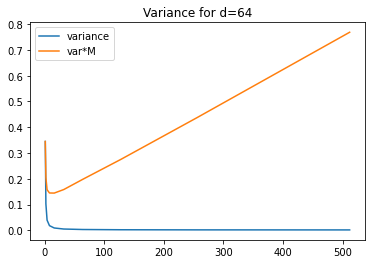

[  1   2   4   8  16  32  64 128 256 512]
[0.34458253414561135, 0.10262827413855714, 0.03935595210612639, 0.018103446881913905, 0.009027339461740754, 0.004941514388126427, 0.0030929620635490535, 0.0021509180164335064, 0.0017088408321588983, 0.0015009153412579189]
[0.34458253414561135, 0.2052565482771143, 0.15742380842450557, 0.14482757505531124, 0.14443743138785206, 0.15812846042004566, 0.19794957206713942, 0.2753175061034888, 0.43746325303267797, 0.7684686547240545]


In [8]:
d = 64
# d_range = [1]
# nrof_ws_range = [1, 2, 3, 5, 10, 25]
# nrof_ws_range = [1, 2, 3, 5, 10, 25, 50, 100]
nrof_ws_range = np.array([2**i for i in range(10)])

nrof_experiments = 100
nrof_x_samples = 100

exp_var_list = []

avg_corrs_list = []

# for d in d_range:
for nrof_ws in nrof_ws_range:
    # print("Doing simulation with d={}:".format(d))
    print("\nDoing simulation with {} different ws.".format(nrof_ws))
    
    """
    Array in each experiments corrensponds to:
    [diffenrent inits of ws, different inits of X, different ws, ..]
    """
    
    avg_corrs = []
    for _ in range(nrof_experiments):
        
        # Sample weights:
        # ws = np.array([get_random_normal(d=d) for _ in range(nrof_ws)])
        ws = np.array([get_random_on_shpere(d=d) for _ in range(nrof_ws)])
        
        # Adverserial weights:
        cumm_weight_sum = np.array([0 for _ in range(d)])
        ws_list = []
        for _ in range(nrof_ws):
            w_basis = get_random_on_shpere(d=d)
            w_dir = w_basis - cumm_weight_sum
            w = w_dir / np.linalg.norm(w_dir)
            cumm_weight_sum = cumm_weight_sum + w
            ws_list.append(w)
        ws = np.array(ws_list)
        
        # print(ws.shape)
        X = np.array([get_random_normal(d=d) for _ in range(nrof_x_samples)])
        # print(X.shape)
        ip = X@ws.T
        ip_relu = relu(ip)
        # print(ip_relu.shape)
        
        sample_mean = np.mean(ip_relu, axis=0)
        # print("sample_mean", sample_mean)
        
        sample_var = np.mean(ip_relu*ip_relu, axis=0) - sample_mean**2
        # print("sample_var", sample_var)
        # Analytic variance:
        an_exp_xsquared = 1/2 * (d*1)
        # print("theoretical var?", an_exp_xsquared - sample_mean**2)
        
        # corr_mat = np.mean(ip_relu[:, None, :]*ip_relu[:, :, None], axis=0) - sample_mean**2
        corr_mat = np.mean(ip_relu[:, None, :]*ip_relu[:, :, None], axis=0) - sample_mean[:, None]*sample_mean[None, :]
        # print("corr_mat", corr_mat)
        
        avg_corr = np.mean(corr_mat)
        # print("avg_corr", avg_corr)
        
        
        var_mat = np.diag(np.diag(corr_mat))
        avg_var = np.mean(var_mat)
        # avg_corr = avg_var
        avg_corrs.append(avg_corr)
    
        # break
        
    print(np.mean(avg_corrs), " - ", avg_corrs[:8])
    avg_corrs_list.append(np.mean(avg_corrs))
    # break

avg_corrs_list_rescales = [ac*w for ac, w in zip(nrof_ws_range, avg_corrs_list)]
plt.plot(nrof_ws_range, avg_corrs_list, label="variance")
plt.plot(nrof_ws_range, avg_corrs_list_rescales, label="var*M")
plt.title("Variance for d={}".format(d))
plt.legend()
plt.show()

print(nrof_ws_range)
print(avg_corrs_list)
print(avg_corrs_list_rescales)



If we set off-diagonal elements of the corr matrix to zero,
then the mean (of the variances) behaves like 1/M.<br>
But if we consider all elements of the correlation matrix,
and pick the weights randomly, 
it seems like the c

